In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random

# import our ensemble stacking model here
#from deepstack.ensemble import StackEnsemble

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data Preparation



---

Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [2]:
from google.colab import drive
breast_cancer_preprocessed  = pickle.load(open('/content/gdrive/My Drive/ITS_S2/KK/preprocessed_breast_cancer_data.pkl', 'rb'))
#breast_cancer_preprocessed

# diagnosis breast cancer dataset
diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']



# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [3]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
hidden_layer_sizes=(100,20)
max_iter=100
batch_size=64 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [4]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [5]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# Hyperparameter Optimization Techniques Using Grid Search

---

Find the best optimal hyperparameter from each model (SVM, DT, LR and also hyperparameter in ANN) and then build your model using the those best hyperparameter combination.

# Diagnosis breast cancer (Original Dataset)

# SVM

In [6]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, fbeta_score
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_result = HalvingGridSearchCV(svm_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_original, diagnosis_y_train_original)
y_pred_svm = svm_result.predict(diagnosis_X_test_original)

In [7]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result.best_score_, svm_result.best_params_))
means = svm_result.cv_results_['mean_test_score']
stds = svm_result.cv_results_['std_test_score']
params = svm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.945773 using Best Hyperparameters: {'C': 50, 'kernel': 'rbf'}
0.912626 (0.067978) with: {'C': 50, 'kernel': 'linear'}
0.915657 (0.065688) with: {'C': 50, 'kernel': 'poly'}
0.924495 (0.074727) with: {'C': 50, 'kernel': 'rbf'}
0.280808 (0.132809) with: {'C': 50, 'kernel': 'sigmoid'}
0.918687 (0.071361) with: {'C': 10, 'kernel': 'linear'}
0.922222 (0.064042) with: {'C': 10, 'kernel': 'poly'}
0.918434 (0.075724) with: {'C': 10, 'kernel': 'rbf'}
0.283586 (0.136443) with: {'C': 10, 'kernel': 'sigmoid'}
0.918687 (0.077577) with: {'C': 1.0, 'kernel': 'linear'}
0.921465 (0.069584) with: {'C': 1.0, 'kernel': 'poly'}
0.929798 (0.073993) with: {'C': 1.0, 'kernel': 'rbf'}
0.439646 (0.190888) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.898232 (0.085881) with: {'C': 0.1, 'kernel': 'linear'}
0.927020 (0.064860) with: {'C': 0.1, 'kernel': 'poly'}
0.923990 (0.070404) with: {'C': 0.1, 'kernel': 'rbf'}
0.645960 (0.108731) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.645960 (0.108731) with: {'C': 0.01

		HASIl UJI COBA SVM
	Akurasi Score:  0.9473684210526315
	Macro Recall Score:  0.9439895185063871
	Macro Precision Score:  0.9439895185063871
	Macro F1-score Score:  0.9439895185063871
	Macro F2-score Score:  0.9439895185063871
	Macro F0.5-score Score:  0.9439895185063871


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<Figure size 1008x576 with 0 Axes>

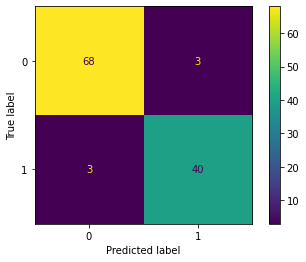

In [8]:
print_model_experiment_results("SVM", diagnosis_y_test_original, y_pred_svm)

# Logistic Regression

In [9]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_original, diagnosis_y_train_original)
y_pred_lr = lr_result.predict(diagnosis_X_test_original)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1350 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is

In [10]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result.best_score_, lr_result.best_params_))
means = lr_result.cv_results_['mean_test_score']
stds = lr_result.cv_results_['std_test_score']
params = lr_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.945894 using Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.911869 (0.073123) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.911869 (0.086895) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.920455 (0.087253) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.923485 (0.085203) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.920202 (0.087777) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.926515 (0.086247) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.920455 (0.096260) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.920455 (0.096260) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.923485 (0.

		HASIl UJI COBA LOGISTIC REGRESSION
	Akurasi Score:  0.9649122807017544
	Macro Recall Score:  0.9626596790042581
	Macro Precision Score:  0.9626596790042581
	Macro F1-score Score:  0.9626596790042581
	Macro F2-score Score:  0.9626596790042581
	Macro F0.5-score Score:  0.9626596790042581


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



<Figure size 1008x576 with 0 Axes>

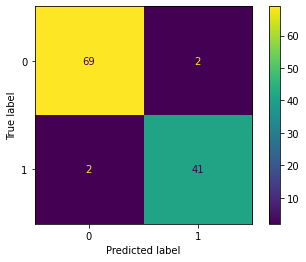

In [11]:
print_model_experiment_results("Logistic Regression", diagnosis_y_test_original, y_pred_lr)

# Naive Bayes

In [12]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
nb_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_original, diagnosis_y_train_original)
y_pred_nb = nb_result.predict(diagnosis_X_test_original)

In [13]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result.best_score_, nb_result.best_params_))
means = nb_result.cv_results_['mean_test_score']
stds = nb_result.cv_results_['std_test_score']
params = nb_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.844988 using Best Hyperparameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': False}
0.628535 (0.126578) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.624495 (0.160952) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.371465 (0.126578) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.371465 (0.126578) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.371465 (0.126578) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.371465 (0.126578) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.628535 (0.126578) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.787879 (0.123603) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.371465 (0.126578) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.371465 (0.126578) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.371465 (0.126578) with: {'alpha': 10, 'class_prior':

		HASIl UJI COBA NAIVE BAYES
	Akurasi Score:  0.8771929824561403
	Macro Recall Score:  0.8601375696036685
	Macro Precision Score:  0.8758974358974358
	Macro F1-score Score:  0.8666889408620113
	Macro F2-score Score:  0.8624536297508878
	Macro F0.5-score Score:  0.8718796137019329


              precision    recall  f1-score   support

           0       0.88      0.93      0.90        71
           1       0.87      0.79      0.83        43

    accuracy                           0.88       114
   macro avg       0.88      0.86      0.87       114
weighted avg       0.88      0.88      0.88       114



<Figure size 1008x576 with 0 Axes>

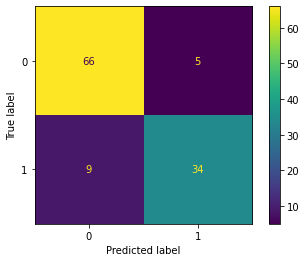

In [14]:
print_model_experiment_results("Naive Bayes", diagnosis_y_test_original, y_pred_nb)

# Desicion Tree

In [15]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_original, diagnosis_y_train_original)
y_pred_dt = dt_result.predict(diagnosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFaile

In [16]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result.best_score_, dt_result.best_params_))
means = dt_result.cv_results_['mean_test_score']
stds = dt_result.cv_results_['std_test_score']
params = dt_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.933514 using Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'splitter': 'best'}
0.602020 (0.110577) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.602020 (0.110577) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.602020 (0.110577) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.602020 (0.110577) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.602020 (0.110577) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.602020 (0.110577) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.602020 (0.110577) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.602020 (0.110577) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.00000

		HASIl UJI COBA DECISION TREE
	Akurasi Score:  0.9385964912280702
	Macro Recall Score:  0.9323616115296429
	Macro Precision Score:  0.9365079365079365
	Macro F1-score Score:  0.9343480049362403
	Macro F2-score Score:  0.9331355665231545
	Macro F0.5-score Score:  0.9356229125136967


              precision    recall  f1-score   support

           0       0.94      0.96      0.95        71
           1       0.93      0.91      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



<Figure size 1008x576 with 0 Axes>

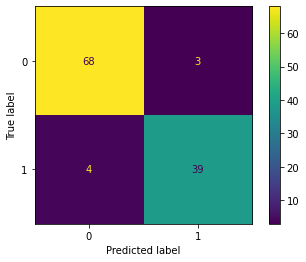

In [17]:
print_model_experiment_results("Decision Tree", diagnosis_y_test_original, y_pred_dt)

# ANN

In [18]:
param_grid = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }
# create model
base_estimator = MLPClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ann_result = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_original, diagnosis_y_train_original)
y_pred_ann = ann_result.predict(diagnosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4860 fits failed out of a total of 24300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/lo

In [19]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result.best_score_, ann_result.best_params_))
means = ann_result.cv_results_['mean_test_score']
stds = ann_result.cv_results_['std_test_score']
params = ann_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.951691 using Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.01, 'batch_size': 100, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.915657 (0.079641) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.924495 (0.073540) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.915152 (0.084097) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.915657 (0.079641) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.677020 (0.159817) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.906313 (0.092090) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.912879 (0.078089) with: {'activation': '

		HASIl UJI COBA ANN
	Akurasi Score:  0.9649122807017544
	Macro Recall Score:  0.9672453324598755
	Macro Precision Score:  0.9594202898550726
	Macro F1-score Score:  0.962987012987013
	Macro F2-score Score:  0.9654573700082244
	Macro F0.5-score Score:  0.9607655626058076


              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



<Figure size 1008x576 with 0 Axes>

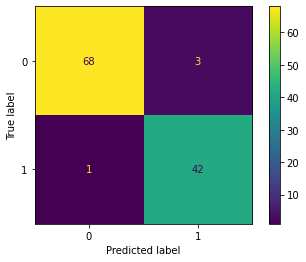

In [20]:
print_model_experiment_results("ANN", diagnosis_y_test_original, y_pred_ann)

# Prognosis breast cancer (Original Dataset)

# SVM

In [21]:
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_result_prognosis = HalvingGridSearchCV(svm_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_original, prognosis_y_train_original)
y_pred_svm_prognosis = svm_result_prognosis.predict(prognosis_X_test_original)

In [22]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result_prognosis.best_score_, svm_result_prognosis.best_params_))
means = svm_result_prognosis.cv_results_['mean_test_score']
stds = svm_result_prognosis.cv_results_['std_test_score']
params = svm_result_prognosis.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.778030 using Best Hyperparameters: {'C': 10, 'kernel': 'linear'}
0.766919 (0.092757) with: {'C': 50, 'kernel': 'linear'}
0.691414 (0.142858) with: {'C': 50, 'kernel': 'poly'}
0.681818 (0.111340) with: {'C': 50, 'kernel': 'rbf'}
0.668687 (0.162505) with: {'C': 50, 'kernel': 'sigmoid'}
0.778030 (0.088912) with: {'C': 10, 'kernel': 'linear'}
0.694444 (0.150150) with: {'C': 10, 'kernel': 'poly'}
0.711616 (0.111939) with: {'C': 10, 'kernel': 'rbf'}
0.662121 (0.155190) with: {'C': 10, 'kernel': 'sigmoid'}
0.758333 (0.067203) with: {'C': 1.0, 'kernel': 'linear'}
0.730051 (0.133578) with: {'C': 1.0, 'kernel': 'poly'}
0.758081 (0.076184) with: {'C': 1.0, 'kernel': 'rbf'}
0.760859 (0.085859) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.764141 (0.069591) with: {'C': 0.1, 'kernel': 'linear'}
0.740909 (0.101459) with: {'C': 0.1, 'kernel': 'poly'}
0.764141 (0.069591) with: {'C': 0.1, 'kernel': 'rbf'}
0.764141 (0.069591) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.764141 (0.069591) with: {'C': 0

		HASIl UJI COBA SVM
	Akurasi Score:  0.8717948717948718
	Macro Recall Score:  0.8003246753246753
	Macro Precision Score:  0.872983870967742
	Macro F1-score Score:  0.8260481712756467
	Macro F2-score Score:  0.8085664335664335
	Macro F0.5-score Score:  0.8510556915544676


              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.88      0.64      0.74        11

    accuracy                           0.87        39
   macro avg       0.87      0.80      0.83        39
weighted avg       0.87      0.87      0.86        39



<Figure size 1008x576 with 0 Axes>

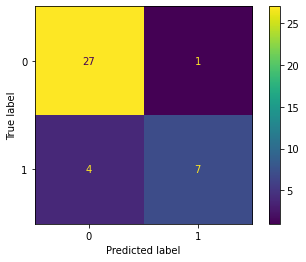

In [23]:
print_model_experiment_results("SVM", prognosis_y_test_original, y_pred_svm_prognosis)

# Logistic Regression

In [24]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_result_prognosis = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_original, prognosis_y_train_original)
y_pred_lr_prognosis = lr_result_prognosis.predict(prognosis_X_test_original)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1350 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is

In [25]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result_prognosis.best_score_, lr_result_prognosis.best_params_))
means = lr_result_prognosis.cv_results_['mean_test_score']
stds = lr_result_prognosis.cv_results_['std_test_score']
params = lr_result_prognosis.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.767424 using Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.721970 (0.153012) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.728030 (0.144435) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.744697 (0.133874) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.741414 (0.121161) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.747222 (0.135639) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.747222 (0.122943) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.747475 (0.123732) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.747475 (0.123732) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.750253 (0.

		HASIl UJI COBA LOGISTIC REGRESSION
	Akurasi Score:  0.7948717948717948
	Macro Recall Score:  0.6363636363636364
	Macro Precision Score:  0.8888888888888888
	Macro F1-score Score:  0.6517857142857143
	Macro F2-score Score:  0.6325474410580794
	Macro F0.5-score Score:  0.7330637007077856


              precision    recall  f1-score   support

           0       0.78      1.00      0.88        28
           1       1.00      0.27      0.43        11

    accuracy                           0.79        39
   macro avg       0.89      0.64      0.65        39
weighted avg       0.84      0.79      0.75        39



<Figure size 1008x576 with 0 Axes>

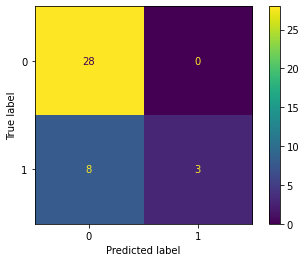

In [26]:
print_model_experiment_results("Logistic Regression", prognosis_y_test_original, y_pred_lr_prognosis)

# Naive Bayes

In [27]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
nb_result_prognosis = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_original, prognosis_y_train_original)
y_pred_nb_prognosis = nb_result_prognosis.predict(prognosis_X_test_original)

In [28]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result_prognosis.best_score_, nb_result_prognosis.best_params_))
means = nb_result_prognosis.cv_results_['mean_test_score']
stds = nb_result_prognosis.cv_results_['std_test_score']
params = nb_result_prognosis.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.785101 using Best Hyperparameters: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.785101 (0.076122) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.716667 (0.101933) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.214899 (0.076122) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.214899 (0.076122) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.214899 (0.076122) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.214899 (0.076122) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.785101 (0.076122) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.634091 (0.145843) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.214899 (0.076122) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.214899 (0.076122) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.214899 (0.076122) with: {'alpha': 10, 'class_prior': [

		HASIl UJI COBA NAIVE BAYES
	Akurasi Score:  0.717948717948718
	Macro Recall Score:  0.5
	Macro Precision Score:  0.358974358974359
	Macro F1-score Score:  0.417910447761194
	Macro F2-score Score:  0.4635761589403974
	Macro F0.5-score Score:  0.3804347826086957


              precision    recall  f1-score   support

           0       0.72      1.00      0.84        28
           1       0.00      0.00      0.00        11

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

<Figure size 1008x576 with 0 Axes>

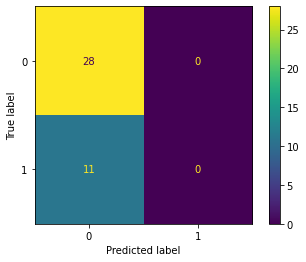

In [29]:
print_model_experiment_results("Naive Bayes", prognosis_y_test_original, y_pred_nb_prognosis)

# Desicion Tree

In [30]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_result_prognosis = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_original, prognosis_y_train_original)
y_pred_dt_prognosis = dt_result_prognosis.predict(prognosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFaile

In [31]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result_prognosis.best_score_, dt_result_prognosis.best_params_))
means = dt_result_prognosis.cv_results_['mean_test_score']
stds = dt_result_prognosis.cv_results_['std_test_score']
params = dt_result_prognosis.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.772222 using Best Hyperparameters: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.772222 (0.055976) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.772222 (0.055976) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.772222 (0.055976) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.772222 (0.055976) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.772222 (0.055976) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.772222 (0.055976) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.772222 (0.055976) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.772222 (0.055976) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.

		HASIl UJI COBA DECISION TREE
	Akurasi Score:  0.717948717948718
	Macro Recall Score:  0.5
	Macro Precision Score:  0.358974358974359
	Macro F1-score Score:  0.417910447761194
	Macro F2-score Score:  0.4635761589403974
	Macro F0.5-score Score:  0.3804347826086957


              precision    recall  f1-score   support

           0       0.72      1.00      0.84        28
           1       0.00      0.00      0.00        11

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

<Figure size 1008x576 with 0 Axes>

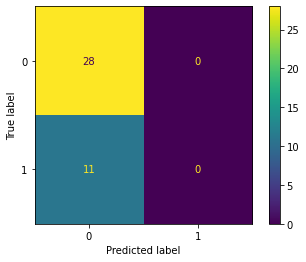

In [32]:
print_model_experiment_results("Decision Tree", prognosis_y_test_original, y_pred_dt_prognosis)

# ANN

In [36]:
param_grid = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }
# create model
base_estimator = MLPClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ann_result_prognosis = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_original, prognosis_y_train_original)
y_pred_ann_prognosis = ann_result_prognosis.predict(prognosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4860 fits failed out of a total of 24300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/lo

In [34]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_prognosis.best_score_, ann_result_prognosis.best_params_))
means = ann_result_prognosis.cv_results_['mean_test_score']
stds = ann_result_prognosis.cv_results_['std_test_score']
params = ann_result_prognosis.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.766919 using Best Hyperparameters: {'activation': 'identity', 'alpha': 0.01, 'batch_size': 20, 'learning_rate': 'constant', 'solver': 'adam'}
0.713889 (0.126339) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.754545 (0.071298) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.737121 (0.083954) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.713889 (0.126339) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.757576 (0.068069) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.748990 (0.092178) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.713889 (0.126339) with: {'activation': 'iden

		HASIl UJI COBA ANN
	Akurasi Score:  0.8717948717948718
	Macro Recall Score:  0.827922077922078
	Macro Precision Score:  0.8482758620689655
	Macro F1-score Score:  0.837092731829574
	Macro F2-score Score:  0.8313632781717888
	Macro F0.5-score Score:  0.8435457516339868


              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.80      0.73      0.76        11

    accuracy                           0.87        39
   macro avg       0.85      0.83      0.84        39
weighted avg       0.87      0.87      0.87        39



<Figure size 1008x576 with 0 Axes>

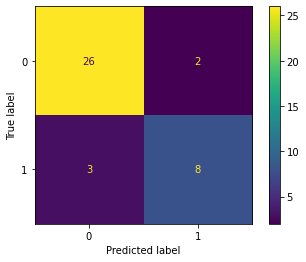

In [35]:
print_model_experiment_results("ANN", prognosis_y_test_original, y_pred_ann_prognosis)